In [1]:
!pip install pandas scikit-learn numpy

In [21]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


## 1- Read the processed datasets

In [6]:

file_path1 = "/kaggle/input/dataset-fully-processed-jobs/final_output_processed_70k.csv"
file_path2 = "/kaggle/input/dataset-fully-processed-jobs/final_output_processed_33k.csv"

# Read the first CSV file into a Pandas DataFrame
df1 = pd.read_csv(file_path1)
df1 = df1[df1['orgTags_CATEGORIES'] != 'NOT FOUND']  # Remove rows where 'orgTags_CATEGORIES' is 'NOT FOUND'

# Read the second CSV file into another Pandas DataFrame
df2 = pd.read_csv(file_path2)
df2 = df2[df2['orgTags_CATEGORIES'] != 'NOT FOUND']  # Remove rows where 'orgTags_CATEGORIES' is 'NOT FOUND'

# Concatenate the two DataFrames into a single DataFrame
df_jobs = pd.concat([df1, df2], ignore_index=True)

# Display the first few rows of the combined DataFrame
df_jobs


,id,sourceCC,source,locale,position_name,position_workType,position_careerLevel,position_department,orgAddress_addressLine,orgAddress_level,...,orgAddress_city,orgCompany_nameOrg,orgCompany_homepage,url,orgTags_CATEGORIES,orgTags_REQUIREMENTS,orgTags_SKILLS,salary_text,salary,years_or_months_experience
0,6137b0bb7d4ffc16c87fb191,us,careerbuilder_us,en_US,Loan Processor - Direct Hire,FULLTIME,NOT FOUND,NOT FOUND,NOT FOUND,99,...,Mesa,AppleOne,NOT FOUND,https://www.careerbuilder.com/job/J3S3Q978N8TQ...,['Administration'],NOT FOUND,"['Underwriting', 'Communication', 'Loans', 'Lo...","Dollar 65,000/Year",5416.666667,5 years
1,6137b1357d4ffc16c87fb70b,us,careerbuilder_us,en_US,Senior R&D Specialist,FULLTIME,SENIOR,NOT FOUND,NOT FOUND,99,...,Fresno,AppleOne,NOT FOUND,https://www.careerbuilder.com/job/J3W0536LYFY0...,['Engineering'],NOT FOUND,"['Prototype (Manufacturing)', 'Control Systems...","Dollar 80,000/Year",6666.666667,15 years
2,6137b21d7d4ffc16c87fc35b,us,careerbuilder_us,en_US,Client Service Manager - Digital Marketing - T...,FULLTIME,NOT FOUND,MARKETING,NOT FOUND,99,...,Las Vegas,AppleOne,NOT FOUND,https://www.careerbuilder.com/job/J3Q4G76NCM09...,"['Journalism, Publishing and Printing']",NOT FOUND,"['Management Consulting', 'Digital Marketing',...","Dollar 70,000/Year",5833.333333,NOT FOUND
3,6137b9427d4ffc16c87ff894,us,careerbuilder_us,en_US,Assembly Worker,FULLTIME,NOT FOUND,NOT FOUND,NOT FOUND,99,...,Winchester,Nesco Resource,NOT FOUND,https://www.careerbuilder.com/job/J3M3BB60897M...,['Manufacturing and Mechanical'],NOT FOUND,"['Blueprinting', 'Complex Problem Solving', 'M...",Dollar 0.00 - Dollar 14.00/Hour,0.0,NOT FOUND
4,6137ba687d4ffc16c87ffdc6,us,careerbuilder_us,en_US,Business Analyst,CONTRACTOR,NOT FOUND,NOT FOUND,NOT FOUND,99,...,Torrance,Robert Half,NOT FOUND,https://www.careerbuilder.com/job/J3V0YG782LYW...,['Manufacturing and Mechanical'],NOT FOUND,"['Software Quality Assurance (SQA)', 'Product ...",Dollar 45.00 - Dollar 52.00/Hour,7200.0,1 years
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70858,64582e691ef6091b1b5871e5,us,jora_us,NOT FOUND,Registered Nurse (RN) ICU,FULLTIME,NOT FOUND,NOT FOUND,NOT FOUND,99,...,Staten Island,Northwell Health,NOT FOUND,https://us.jora.com/job/Registered-Nurse-86187...,"['Arts', 'Fashion Design']",NOT FOUND,NOT FOUND,NOT FOUND,NOT FOUND,24 months
70859,645836201ef6091b1b5883a8,us,jora_us,NOT FOUND,Title Environmental Services - Manager Training,FULLTIME,NOT FOUND,NOT FOUND,NOT FOUND,99,...,Waterbury,Healthcare Services Group,NOT FOUND,https://us.jora.com/job/Manager-5012e55ea8a363...,"['Management', 'Environmental Manager']",NOT FOUND,NOT FOUND,NOT FOUND,NOT FOUND,45 years
70860,64582e631ef6091b1b5871d7,us,jora_us,NOT FOUND,Registered Nurse,FULLTIME,NOT FOUND,NOT FOUND,NOT FOUND,99,...,New Hyde Park,Northwell Health,NOT FOUND,https://us.jora.com/job/Registered-Nurse-182b8...,"['Arts', 'Fashion Design']",NOT FOUND,NOT FOUND,NOT FOUND,NOT FOUND,NOT FOUND
70861,64582e641ef6091b1b5871d8,us,jora_us,NOT FOUND,Registered Nurse (RN)-Med/Surg Unit 3A,FULLTIME,NOT FOUND,NOT FOUND,NOT FOUND,99,...,Staten Island,Northwell Health,NOT FOUND,https://us.jora.com/job/Registered-Nurse-271bb...,"['Arts', 'Fashion Design']",NOT FOUND,NOT FOUND,NOT FOUND,NOT FOUND,24 months


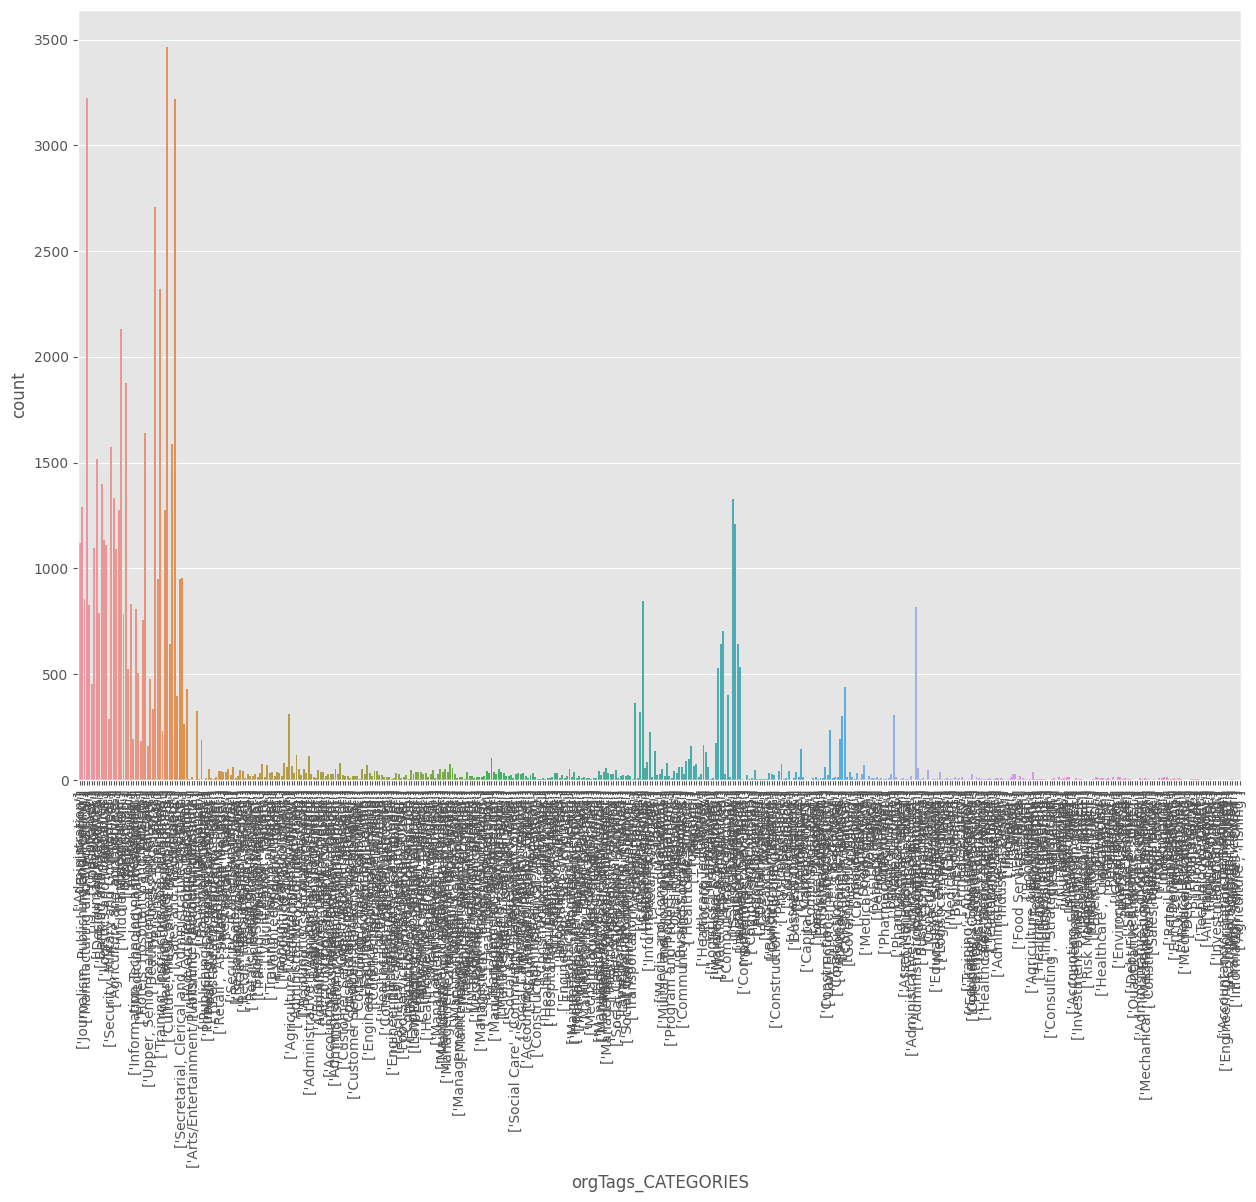

In [19]:
plt.figure(figsize=(15,10))
plt.style.use('ggplot')
sns.countplot(x=df_jobs['orgTags_CATEGORIES'])
plt.xticks(rotation=90)
plt.show()

In [28]:
# Display unique categories with counts
unique_categories = df_jobs['orgTags_CATEGORIES'].value_counts()
print(unique_categories)


orgTags_CATEGORIES
['Marketing, Advertising and PR']    3467
['Manufacturing and Mechanical']     3226
['Sales and Procurement']            3219
['Legal']                            2711
['Finance']                          2321
                                     ... 
['Hedge Funds']                         1
['Bookkeeping']                         1
['Training', 'Apprentice Year']         1
['Information Services', 'ONET']        1
['Agriculture', 'Fishing']              1
Name: count, Length: 477, dtype: int64


### First try
- X → 'position_name'
- y → 'orgTags_CATEGORIES'


In [31]:
# Data Preprocessing
df_jobs_cleaned = df_jobs.dropna(subset=['orgTags_CATEGORIES', 'position_name'])
X = df_jobs_cleaned['position_name']
y = df_jobs_cleaned['orgTags_CATEGORIES']

# Encode categorical feature
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training, testing, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Feature Extraction using TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Model Training (Random Forest Classifier as an example)
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train_tfidf, y_train)

# Model Evaluation on Train Data
y_pred_train = classifier.predict(X_train_tfidf)
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {train_accuracy}")

# Model Evaluation on Test Data
y_pred_test = classifier.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy}")

# Model Evaluation on Validation Data (if applicable)
y_pred_val = classifier.predict(X_val_tfidf)
val_accuracy = accuracy_score(y_val, y_pred_val)
print(f"Validation Accuracy: {val_accuracy}")


Train Accuracy: 0.7388338782134205
Test Accuracy: 0.44782332604247516
Validation Accuracy: 0.4551612220419107


In [36]:
# Data Preprocessing
df_jobs_cleaned = df_jobs.dropna(subset=['orgTags_CATEGORIES', 'position_name'])
X = df_jobs_cleaned['position_name']
y = df_jobs_cleaned['orgTags_CATEGORIES']

# Encode categorical feature
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Feature Extraction using TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Model Training (Random Forest Classifier as an example)
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train_tfidf, y_train)

# Model Evaluation
y_pred = classifier.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

# Example predictions
new_positions = ['Software Engineer', 'Marketing Manager', 'Sales Representative']
new_positions_tfidf = tfidf_vectorizer.transform(new_positions)
predicted_categories = label_encoder.inverse_transform(classifier.predict(new_positions_tfidf))
print(predicted_categories)


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.51      0.48      0.50        58
           3       0.27      0.28      0.28       266
           5       1.00      0.18      0.31        11
           6       0.00      0.00      0.00        15
           7       0.33      0.67      0.44         3
           8       0.00      0.00      0.00         4
           9       0.33      0.17      0.22         6
          11       0.47      0.34      0.39        74
          12       0.79      0.54      0.64        68
          13       0.64      0.60      0.62        15
          14       0.23      0.15      0.18       224
          15       0.00      0.00      0.00         2
          16       0.33      0.43      0.38        14
          17       0.00      0.00      0.00         5
          18       0.50      0.14      0.22        28
          20       0.00      0.00      0.00         8
          21       0.33    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

### Second try
- X → 'position_name', ‘orgCompany_nameOrg’
- y → 'orgTags_CATEGORIES'


In [23]:
# Data Preprocessing
df_jobs_cleaned = df_jobs.dropna(subset=['orgTags_CATEGORIES', 'position_name', 'orgCompany_nameOrg'])
X = df_jobs_cleaned['position_name'] + ' ' + df_jobs_cleaned['orgCompany_nameOrg']  # Combine position and company name
y = df_jobs_cleaned['orgTags_CATEGORIES']

# Encode categorical feature
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training, testing, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Feature Extraction using TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Model Training (Random Forest Classifier as an example)
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train_tfidf, y_train)

# Model Evaluation on Train Data
y_pred_train = classifier.predict(X_train_tfidf)
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {train_accuracy}")

# Model Evaluation on Test Data
y_pred_test = classifier.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy}")

# Model Evaluation on Validation Data (if applicable)
y_pred_val = classifier.predict(X_val_tfidf)
val_accuracy = accuracy_score(y_val, y_pred_val)
print(f"Validation Accuracy: {val_accuracy}")

Train Accuracy: 0.8368887739022038
Test Accuracy: 0.4936851760389473
Validation Accuracy: 0.4976363508078741


### Third try
- X → 'position_name', orgTags_SKILLS’
- y → 'orgTags_CATEGORIES'



In [25]:
# Data Preprocessing
df_jobs_cleaned = df_jobs.dropna(subset=['orgTags_CATEGORIES', 'position_name', 'orgTags_SKILLS'])
X = df_jobs_cleaned['position_name'] + ' ' + df_jobs_cleaned['orgTags_SKILLS']  # Combine position and company name
y = df_jobs_cleaned['orgTags_CATEGORIES']

# Encode categorical feature
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training, testing, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Feature Extraction using TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Model Training (Random Forest Classifier as an example)
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train_tfidf, y_train)

# Model Evaluation on Train Data
y_pred_train = classifier.predict(X_train_tfidf)
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {train_accuracy}")

# Model Evaluation on Test Data
y_pred_test = classifier.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy}")

# Model Evaluation on Validation Data (if applicable)
y_pred_val = classifier.predict(X_val_tfidf)
val_accuracy = accuracy_score(y_val, y_pred_val)
print(f"Validation Accuracy: {val_accuracy}")

Train Accuracy: 0.8797422207587553
Test Accuracy: 0.4967191138079447
Validation Accuracy: 0.49721301065406054
